In [28]:

# ==========================================
# Imports and Setup
# ==========================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
NumPy version: 2.0.2
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6

Using device: cuda


In [29]:

# ==========================================
# Utility Functions
# ==========================================

def plot_loss(train_loss, test_loss=None, fs=14, lw=2, savefile=None, figsize=(10, 5)):
    """Plot training and test loss curves."""
    plt.figure(figsize=figsize)
    plt.plot(train_loss, label='Train Loss', linewidth=lw, color='blue')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss', linewidth=lw, color='red')
    plt.xlabel('Epoch', fontsize=fs)
    plt.ylabel('MSE Loss', fontsize=fs)
    plt.yscale('log')
    plt.legend(fontsize=fs)
    plt.grid(True, alpha=0.3)
    plt.title('Training History', fontsize=fs+2, fontweight='bold')
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=150, bbox_inches='tight')
        print(f"Loss plot saved to {savefile}")
    plt.show()


def plot_2d_field(ax, u, extent=[0, 2*np.pi, 0, 2*np.pi], cmap='jet',
                  vmin=None, vmax=None, title=None, xlabel='x', ylabel='y'):
    """Plot a 2D field with colorbar."""
    im = ax.imshow(u, origin='lower', extent=extent, cmap=cmap,
                   vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    return im


def compute_relative_l2_error(pred, truth):
    """Compute relative L2 error: ||pred - truth|| / ||truth||"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)


print("Utility functions defined!")

Utility functions defined!


In [30]:
# ==========================================
# Dataset Class
# ==========================================

class BurgersDataset(Dataset):
    """Memory-efficient dataset for Burgers equation DeepONet training."""

    def __init__(self, u0_data, trunk_data, u_data, device='cpu'):
        """
        Parameters:
        -----------
        u0_data : torch.Tensor, shape (N, nx*ny)
            Initial conditions (branch input), already flattened
        trunk_data : torch.Tensor, shape (M, 3)
            Trunk coordinates (x, y, t) - SHARED across all samples
        u_data : torch.Tensor, shape (N, M)
            Solution values at trunk points
        """
        self.u0_data = u0_data.to(device)
        self.trunk_data = trunk_data.to(device)  # Store but don't return in __getitem__
        self.u_data = u_data.to(device)
        self.device = device

    def __len__(self):
        return len(self.u0_data)

    def __getitem__(self, idx):
        # Return only u0 and u (solution), NOT trunk
        # Trunk is the same for all samples and will be passed separately
        return (self.u0_data[idx],      # Already flattened initial condition
                self.u_data[idx])        # Solution at all trunk points


print("Dataset class defined!")

Dataset class defined!


In [31]:
# ==========================================
# DeepONet Architecture
# ==========================================

# ---------- CNN-BASED BRANCH NETWORK (CHANGE) ----------
class BranchNet(nn.Module):
    """
    Improved CNN-based branch for DeepONet.
    Preserves tensor structure and increases operator capacity.
    """
    def __init__(self, in_channels, branch_out_dim):
        super(BranchNet, self).__init__()
        self.branch_out_dim = branch_out_dim

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # 🔥 NEW BLOCK (critical improvement)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((4, 4))
        )

        # 256 feature maps × 4 × 4 = 4096
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, branch_out_dim)
        )

    def forward(self, x):
        features = self.conv(x)
        out = self.fc(features)
        return out




class TrunkNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            # 🔥 NEW LAYER (Priority 3)
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)



class DeepONet(nn.Module):
    """Deep Operator Network for Burgers equation with memory-efficient chunked processing"""
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, p, chunk_size=2048):
        super(DeepONet, self).__init__()
        self.branch = BranchNet(branch_input_dim, p)
        self.trunk = TrunkNet(trunk_input_dim, hidden_dim, p)
        self.bias = nn.Parameter(torch.zeros(1))
        self.p = p
        self.chunk_size = chunk_size

def forward(self, u0, xyt):
        """
        Memory-efficient forward pass with chunked trunk processing

        u0: (batch_size, C, H, W)    # CHANGED: tensorial initial condition
        xyt: (num_trunk_points, trunk_input_dim)
        """
        batch_size = u0.shape[0]
        num_trunk = xyt.shape[0]

        # Encode branch (initial conditions)
        b = self.branch(u0)  # (batch_size, p)  # CHANGED: branch is now CNN taking (B,C,H,W)

        # Process trunk in chunks to save memory
        outputs = []
        for i in range(0, num_trunk, self.chunk_size):
            end_idx = min(i + self.chunk_size, num_trunk)
            xyt_chunk = xyt[i:end_idx]  # (chunk_size, trunk_input_dim)

            # Encode trunk chunk
            t_chunk = self.trunk(xyt_chunk)  # (chunk_size, p)

            # Compute output for this chunk
            out_chunk = torch.matmul(b, t_chunk.T)  # (batch_size, chunk_size)
            outputs.append(out_chunk)

        # Concatenate all chunks
        out = torch.cat(outputs, dim=1) + self.bias  # (batch_size, num_trunk_points)
        return out


print("DeepONet architecture defined with chunked processing!")

DeepONet architecture defined with chunked processing!


# **DATA GENERATION CODE**

In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from tqdm import tqdm
# import warnings

# warnings.filterwarnings('ignore')


# class Burgers2DSolver:
#     def __init__(self, nx=64, ny=64, T=1.0, nt=200, nu=0.05, length=2*np.pi, dealias=True):
#         self.nx, self.ny = int(nx), int(ny)
#         self.T, self.nt = float(T), int(nt)
#         self.nu = float(nu)
#         self.length = float(length)
#         self.dealias = bool(dealias)

#         # time step
#         # ensure nt>1
#         self.dt = self.T / max(self.nt - 1, 1)

#         # spatial grid (physical)
#         self.x = np.linspace(0.0, self.length, self.nx, endpoint=False)
#         self.y = np.linspace(0.0, self.length, self.ny, endpoint=False)
#         self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

#         # spectral wave numbers (full FFT layout)
#         kx = 2.0 * np.pi * np.fft.fftfreq(self.nx, d=self.length / self.nx)
#         ky = 2.0 * np.pi * np.fft.fftfreq(self.ny, d=self.length / self.ny)
#         self.KX, self.KY = np.meshgrid(kx, ky, indexing='ij')  # shapes (nx, ny)
#         self.K2 = self.KX**2 + self.KY**2

#         # time vector
#         self.t = np.linspace(0.0, self.T, self.nt)

#         # build correct 2/3 de-alias mask (full FFT shape)
#         if self.dealias:
#             kx_full = kx
#             ky_full = ky
#             KX_full, KY_full = np.meshgrid(kx_full, ky_full, indexing='ij')
#             k_mag = np.sqrt(KX_full**2 + KY_full**2)
#             k_cut = (2.0 / 3.0) * np.max(np.sqrt(kx_full**2 + ky_full**2))
#             self.mask = (k_mag <= k_cut).astype(np.float64)  # 1 where kept, 0 where cut
#         else:
#             self.mask = np.ones((self.nx, self.ny), dtype=np.float64)

#     def generate_initial_condition(self, num_samples, l=0.25, sigma=1.5, seed=None):
#         """
#         Generate smooth initial conditions as filtered Gaussian fields using full FFT.
#           - l: correlation length parameter (bigger -> smoother)
#           - sigma: amplitude envelope scale
#         Returns: array (num_samples, nx, ny)
#         """
#         if seed is not None:
#             np.random.seed(seed)
#         print(f"Generating {num_samples} smooth initial conditions...")
#         u0_samples = np.zeros((num_samples, self.nx, self.ny), dtype=np.float64)

#         # precompute k^2 (same shape as K2)
#         ksq = self.K2

#         for i in tqdm(range(num_samples), desc="Generating ICs"):
#             # white noise
#             noise = np.random.randn(self.nx, self.ny)

#             # spectral transform
#             noise_hat = np.fft.fft2(noise)

#             # Gaussian spectral filter (heat-kernel-like)
#             envelope = sigma * np.exp(-0.5 * (l**2) * ksq)

#             u0_hat = noise_hat * envelope

#             # back to physical
#             u0 = np.real(np.fft.ifft2(u0_hat))

#             # normalize to mean 0, std 1
#             u0 = (u0 - np.mean(u0)) / (np.std(u0) + 1e-12)

#             u0_samples[i] = u0

#         return u0_samples

#     def compute_nonlinear_hat(self, u_hat):
#         """
#         Compute the spectral representation of the nonlinear advective term:
#             N(u) = u * (u_x + u_y)
#         Steps:
#             - compute u = ifft2(u_hat)
#             - compute spectral ux_hat = i*KX * u_hat, likewise uy_hat
#             - ux = ifft2(ux_hat), uy = ifft2(uy_hat)
#             - nonlinear = u * (ux + uy)
#             - return fft2(nonlinear) (spectral)
#         The returned array is in full FFT shape (nx,ny), complex.
#         """
#         # spectral derivatives
#         ux_hat = 1j * self.KX * u_hat
#         uy_hat = 1j * self.KY * u_hat

#         # physical fields
#         u = np.real(np.fft.ifft2(u_hat))
#         ux = np.real(np.fft.ifft2(ux_hat))
#         uy = np.real(np.fft.ifft2(uy_hat))

#         nonlinear = u * (ux + uy)

#         nonlinear_hat = np.fft.fft2(nonlinear)

#         # de-alias: zero high modes (if desired)
#         if self.dealias:
#             nonlinear_hat = nonlinear_hat * self.mask

#         return nonlinear_hat

#     def solve(self, u0, verbose=False, auto_reduce_dt=False):
#         """
#         Stable pseudo-spectral RK4 + integrating-factor solver for 2D viscous Burgers.
#         Returns array (nt, nx, ny) in physical space.
#         If instability occurs, returns None.
#         """

#         # -------------------------------------------------------
#         # 0. Start in spectral space (use fft2 / ifft2 consistently)
#         # -------------------------------------------------------
#         u_hat = np.fft.fft2(u0).astype(np.complex128)

#         # -------------------------------------------------------
#         # 1. CFL check for explicit advective term (optional)
#         # -------------------------------------------------------
#         max_u = np.max(np.abs(u0))
#         dx = self.length / float(self.nx)
#         cfl = self.dt * max_u / dx

#         if verbose:
#             print(f"[solve] max|u0|={max_u:.3e}, dx={dx:.3e}, dt={self.dt:.3e}, CFL={cfl:.3e}")

#         if cfl > 0.3:
#             if verbose:
#                 print(f"[warning] CFL={cfl:.3f} > 0.3; may be unstable.")
#             if auto_reduce_dt:
#                 # Compute new dt
#                 desired_dt = 0.05 * dx / (max_u + 1e-12) # Reduced stability factor
#                 new_nt = int(np.ceil(self.T / desired_dt)) + 1
#                 if verbose:
#                     print(f"[solve] auto-adjust dt: increasing nt from {self.nt} to {new_nt}")
#                 self.nt = new_nt
#                 self.dt = self.T / (self.nt - 1)
#                 self.t = np.linspace(0, self.T, self.nt)

#         # -------------------------------------------------------
#         # 2. Prepare output array
#         # -------------------------------------------------------
#         solution = np.zeros((self.nt, self.nx, self.ny), dtype=np.float64)
#         solution[0] = np.real(np.fft.ifft2(u_hat))

#         # -------------------------------------------------------
#         # 3. Precompute integrating factor for diffusion
#         #    Fourier Laplacian = -K^2, so diffusion factor = exp( nu * (-K2) * dt )
#         # -------------------------------------------------------
#         exp_factor = np.exp(self.nu * (-self.K2) * self.dt)  # shape (nx,ny)

#         # -------------------------------------------------------
#         # 4. Main time stepping loop (RK4 on nonlinearity)
#         # -------------------------------------------------------
#         for n in range(1, self.nt):

#             # --- Nonlinear RHS in spectral space ---
#             # compute_nonlinear_hat must return FFT of [u*(ux + uy)]
#             k1 = -self.compute_nonlinear_hat(u_hat)
#             k2 = -self.compute_nonlinear_hat(u_hat + 0.5 * self.dt * k1)
#             k3 = -self.compute_nonlinear_hat(u_hat + 0.5 * self.dt * k2)
#             k4 = -self.compute_nonlinear_hat(u_hat + self.dt * k3)

#             # RK4 for nonlinear part only
#             u_hat_tent = u_hat + (self.dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

#             # Diffusion via integrating factor
#             u_hat_new = u_hat_tent * exp_factor

#             # De-aliasing (masks high frequencies)
#             if self.dealias:
#                 u_hat_new = u_hat_new * self.mask

#             # Safety: abort on NaNs / Infs
#             if not np.isfinite(u_hat_new).all():
#                 if verbose:
#                     print(f"[solve] non-finite encountered at step {n}, abort.")
#                 return None

#             # Advance
#             u_hat = u_hat_new
#             u_phys = np.real(np.fft.ifft2(u_hat))
#             solution[n] = u_phys

#         return solution


# def visualize_data_check(filename='Burgers2D_samples.npz', sample_index=0):
#     if not os.path.exists(filename):
#         print("File not found:", filename)
#         return
#     print("\nVisualizing data check...")
#     data = np.load(filename)
#     sol = data['solutions'][sample_index]  # shape (nt, nx, ny)
#     t = data['t']

#     fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#     times = [0, len(t) // 2, -1]

#     # set dynamic vmin/vmax for visibility
#     vmin = np.min(sol)
#     vmax = np.max(sol)

#     for ax, idx in zip(axes, times):
#         im = ax.imshow(sol[idx].T, origin='lower', cmap='jet',
#                        vmin=vmin, vmax=vmax,
#                        extent=[0, 1.0 * np.max(data['x']), 0, 1.0 * np.max(data['y'])])
#         ax.set_title(f"t = {t[idx]:.3f}")
#         plt.colorbar(im, ax=ax)

#     plt.tight_layout()
#     plt.savefig('data_check_sample.png')
#     print("✓ Saved 'data_check_sample.png'")
#     plt.show()


# def generate_burgers_data(
#         num_samples=100,
#         nx=64, ny=64,
#         nt=100,
#         nu=0.01,
#         out_file='Burgers2D_samples.npz',
#         seed=None,
#         normalize=True,
#         verbose=False,
#         auto_reduce_dt=False
#     ):
#     """
#     Corrected & stable dataset builder for 2+1D Burgers.
#     Includes proper CFL checks, stable solver, AND correct normalization.
#     """

#     # --------------------------------------
#     # 1. Create solver
#     # --------------------------------------
#     solver = Burgers2DSolver(
#         nx=nx, ny=ny,
#         T=1.0, nt=nt,
#         nu=nu,
#         length=2*np.pi,
#         dealias=True
#     )

#     # --------------------------------------
#     # 2. Generate initial conditions
#     # --------------------------------------
#     u0s = solver.generate_initial_condition(
#         num_samples=num_samples,
#         l=0.25,
#         sigma=1.5,
#         seed=seed
#     )

#     print("\nSolving samples (spectral solver)...")
#     solutions = []
#     valid_u0 = []

#     # --------------------------------------
#     # 3. Solve for each sample
#     # --------------------------------------
#     for i in tqdm(range(num_samples), desc="Solving"):

#         u0 = u0s[i]

#         # ---------- CFL CHECK ----------
#         max_u = np.max(np.abs(u0))
#         dx = solver.length / solver.nx
#         dt = solver.dt
#         cfl = dt * max_u / (dx + 1e-12)

#         if cfl > 0.25:
#             print(f"[CFL WARNING] sample {i}: CFL={cfl:.3f} > 0.25")
#             if auto_reduce_dt:
#                 new_nt = int(np.ceil(solver.T / (0.05 * dx / max_u))) # Reduced stability factor
#                 if new_nt < solver.nt: # Ensure nt is increased, not decreased
#                     new_nt = solver.nt * 2 # Fallback to doubling nt if calculated new_nt is smaller
#                 print(f"  Auto-fix: nt {solver.nt} \u2192 {new_nt}")
#                 solver = Burgers2DSolver(nx, ny, T=1.0, nt=new_nt, nu=nu, length=2*np.pi, dealias=True)
#                 # Update dt after re-initializing solver
#                 dt = solver.dt

#         # ---------- SOLVE ----------
#         sol = solver.solve(u0, verbose=verbose, auto_reduce_dt=auto_reduce_dt)

#         if sol is None:
#             if verbose:
#                 print(f"[generate] Skipping unstable sample {i}.")
#             continue

#         solutions.append(sol)
#         valid_u0.append(u0)

#     # --------------------------------------
#     # 4. Convert to arrays
#     # --------------------------------------
#     if len(solutions) == 0:
#         raise RuntimeError("No valid solutions were generated.")

#     solutions = np.array(solutions)        # (N_valid, nt, nx, ny)
#     valid_u0 = np.array(valid_u0)          # (N_valid, nx, ny)

#     # --------------------------------------
#     # 5. NORMALIZATION (CORRECTED)  ← UPDATED
#     # --------------------------------------
#     if normalize:

#         # (A) Normalize solutions using global mean/std of SOLUTIONS ONLY
#         sol_vals = solutions.reshape(-1)
#         sol_mean = float(np.nanmean(sol_vals))
#         sol_std = float(np.nanstd(sol_vals) + 1e-12)
#         solutions = (solutions - sol_mean) / sol_std

#         # (B) Normalize u0 using its OWN mean/std — NOT sol_mean/sol_std
#         u0_vals = valid_u0.reshape(-1)
#         u0_mean = float(np.nanmean(u0_vals))
#         u0_std = float(np.nanstd(u0_vals) + 1e-12)
#         valid_u0 = (valid_u0 - u0_mean) / u0_std

#         if verbose:
#             print(f"[normalize] sol_mean={sol_mean:.4f}, sol_std={sol_std:.4f}")
#             print(f"[normalize] u0_mean={u0_mean:.4f}, u0_std={u0_std:.4f}")

#     else:
#         sol_mean = 0.0
#         sol_std = 1.0
#         u0_mean = 0.0
#         u0_std = 1.0

#     # --------------------------------------
#     # 6. Keep u0 as (N_valid, nx, ny) for CNN-based branch input
#     # --------------------------------------

#     N_valid = len(valid_u0)
#     # valid_u0 has shape (N_valid, nx, ny)

#     # 7. SAVE
#     np.savez_compressed(
#       out_file,
#       u0_samples=valid_u0,   # <-- no flatten
#       solutions=solutions,
#       t=solver.t,
#       x=solver.x,
#       y=solver.y,
#       sol_mean=sol_mean,
#       sol_std=sol_std,
#       u0_mean=u0_mean,
#       u0_std=u0_std
#   )

#     print(f"\nSaved dataset to {out_file} (valid samples: {N_valid})")

#     # --------------------------------------
#     # 8. Visualization
#     # --------------------------------------
#     try:
#         visualize_data_check(out_file, sample_index=0)
#     except Exception as e:
#         if verbose:
#             print("[visualize] error:", e)

#     return valid_u0, solutions, solver.t, solver.x, solver.y, sol_mean, sol_std, u0_mean, u0_std


# # =========================
# # QUICK DEMO CALL
# # =========================
# if __name__ == "__main__":
#     print("\n" + "="*60)
#     print("PRODUCTION: Corrected Data Generation Demo (FINAL PATCH)")
#     print("="*60 + "\n")

#     generate_burgers_data(
#         num_samples=40,
#         nx=64, ny=64,
#         nt=80,
#         nu=0.01,
#         out_file='Burgers2D_samples_demo.npz',
#         seed=1,
#         normalize=True,
#         verbose=True,
#         auto_reduce_dt=True  # Changed to True
#     )

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# ============================================================
# 2D Burgers Pseudo-Spectral Solver
# ============================================================
class Burgers2DSolver:
    def __init__(self, nx=64, ny=64, T=1.0, nt=200, nu=0.05,
                 length=2*np.pi, dealias=True):

        self.nx, self.ny = int(nx), int(ny)
        self.T, self.nt = float(T), int(nt)
        self.nu = float(nu)
        self.length = float(length)
        self.dealias = bool(dealias)

        self.dt = self.T / (self.nt - 1)

        # physical grid
        self.x = np.linspace(0, self.length, self.nx, endpoint=False)
        self.y = np.linspace(0, self.length, self.ny, endpoint=False)

        # spectral grid
        kx = 2*np.pi*np.fft.fftfreq(self.nx, d=self.length/self.nx)
        ky = 2*np.pi*np.fft.fftfreq(self.ny, d=self.length/self.ny)
        self.KX, self.KY = np.meshgrid(kx, ky, indexing="ij")
        self.K2 = self.KX**2 + self.KY**2

        self.t = np.linspace(0, self.T, self.nt)

        # 2/3 dealiasing mask
        if self.dealias:
            k_mag = np.sqrt(self.K2)
            k_cut = (2/3)*np.max(k_mag)
            self.mask = (k_mag <= k_cut).astype(float)
        else:
            self.mask = np.ones_like(self.K2)

        # diffusion integrating factor
        self.exp_factor = np.exp(-self.nu * self.K2 * self.dt)

    def generate_initial_condition(self, num_samples,
                                   l=0.6, sigma=1.0, seed=None):
        if seed is not None:
            np.random.seed(seed)

        u0s = np.zeros((num_samples, self.nx, self.ny))

        for i in tqdm(range(num_samples), desc="Generating ICs"):
            noise = np.random.randn(self.nx, self.ny)
            noise_hat = np.fft.fft2(noise)
            envelope = np.exp(-0.5*(l**2)*self.K2)
            u0 = np.real(np.fft.ifft2(noise_hat * envelope))
            u0 = (u0 - u0.mean()) / (u0.std() + 1e-12)
            u0s[i] = sigma * u0

        return u0s

    def nonlinear_hat(self, u_hat):
        ux_hat = 1j * self.KX * u_hat
        uy_hat = 1j * self.KY * u_hat

        u  = np.real(np.fft.ifft2(u_hat))
        ux = np.real(np.fft.ifft2(ux_hat))
        uy = np.real(np.fft.ifft2(uy_hat))

        nl = u * (ux + uy)
        nl_hat = np.fft.fft2(nl)

        if self.dealias:
            nl_hat *= self.mask

        return nl_hat

    def solve(self, u0, verbose=False):
        u_hat = np.fft.fft2(u0)
        sol = np.zeros((self.nt, self.nx, self.ny))
        sol[0] = u0.copy()

        for n in range(1, self.nt):
            k1 = -self.nonlinear_hat(u_hat)
            k2 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k1)
            k3 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k2)
            k4 = -self.nonlinear_hat(u_hat + self.dt*k3)

            u_hat = u_hat + (self.dt/6)*(k1 + 2*k2 + 2*k3 + k4)
            u_hat = u_hat * self.exp_factor

            if not np.isfinite(u_hat).all():
                if verbose:
                    print(f"Instability at step {n}")
                return None

            sol[n] = np.real(np.fft.ifft2(u_hat))

        return sol


# ============================================================
# Dataset Generator
# ============================================================
def generate_burgers_data(
    num_samples=40,
    nx=64, ny=64,
    nt=200,
    nu=0.05,
    out_file="Burgers2D_samples.npz",
    seed=1,
    normalize=True,
    verbose=True
):

    solver = Burgers2DSolver(nx, ny, T=1.0, nt=nt, nu=nu)
    u0s = solver.generate_initial_condition(num_samples, seed=seed)

    solutions, valid_u0 = [], []

    for i in tqdm(range(num_samples), desc="Solving"):
        sol = solver.solve(u0s[i], verbose=verbose)
        if sol is not None:
            solutions.append(sol)
            valid_u0.append(u0s[i])

    if len(solutions) == 0:
        raise RuntimeError("All solutions unstable — check parameters.")

    solutions = np.array(solutions)
    valid_u0 = np.array(valid_u0)

    if normalize:
        sol_mean, sol_std = solutions.mean(), solutions.std() + 1e-12
        u0_mean, u0_std = valid_u0.mean(), valid_u0.std() + 1e-12
        solutions = (solutions - sol_mean) / sol_std
        valid_u0 = (valid_u0 - u0_mean) / u0_std
    else:
        sol_mean = sol_std = u0_mean = u0_std = 0.0

    np.savez_compressed(
        out_file,
        u0_samples=valid_u0,
        solutions=solutions,
        t=solver.t,
        x=solver.x,
        y=solver.y,
        sol_mean=sol_mean,
        sol_std=sol_std,
        u0_mean=u0_mean,
        u0_std=u0_std
    )

    print(f"Saved dataset → {out_file}")
    return valid_u0, solutions


# ============================================================
# Demo
# ============================================================
if __name__ == "__main__":
    generate_burgers_data()


Solving: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Saved dataset → Burgers2D_samples.npz


In [34]:
# ==========================================
# Data Loading (Memory-Efficient & Dynamic)
# ==========================================

# Load data with memory mapping
data_path = 'Burgers2D_samples.npz'
print(f"Loading data from {data_path} (memory-mapped mode)...")

data = np.load(data_path, mmap_mode='r')  # Memory-mapped read
print(f"Keys in data file: {list(data.keys())}")

# Subsampling configuration
spatial_stride = 4
temporal_stride = 10

# Load full grid coordinates to determine original dimensions
x_full = data['x']
y_full = data['y']
t_full = data['t']

# Extract metadata from full coordinate lengths
nx = len(x_full)
ny = len(y_full)
nt = len(t_full)
print(f"Full grid: nx={nx}, ny={ny}, nt={nt}")

nx_sub = nx // spatial_stride
ny_sub = ny // spatial_stride
nt_sub = nt // temporal_stride

print(f"\nSubsampled grid: nx={nx_sub}, ny={ny_sub}, nt={nt_sub}")

# Apply subsampling
x = x_full[::spatial_stride]
y = y_full[::spatial_stride]
t = t_full[::temporal_stride]

# Load u0 samples
u0_all = np.array(data['u0_samples'])
print(f"u0_samples shape: {u0_all.shape}")

# --- FIX: Dynamically set N_total based on actual data size ---
N_total = u0_all.shape[0]
split_ratio = 0.8
N_train = int(N_total * split_ratio)
N_test = N_total - N_train

print(f"\nAdjusted dataset sizes: Total={N_total}, Train={N_train}, Test={N_test}")

print(f"Processing solutions in batches...")
u_all_list = []

# Process all data first, then split (Robust for small/odd-sized datasets)
for batch_idx in range(0, N_total, 100):
    end_idx = min(batch_idx + 100, N_total)

    # Load batch of solutions and immediately subsample
    u_batch = np.array(data['solutions'][batch_idx:end_idx, ::temporal_stride, ::spatial_stride, ::spatial_stride])

    # Flatten to trunk format
    batch_size_actual = u_batch.shape[0]
    u_flat = u_batch.reshape(batch_size_actual, -1)

    u_all_list.append(u_flat)
    print(f"  Processed samples {batch_idx}-{end_idx-1}")

# Stack all processed data
u_all = np.vstack(u_all_list)

# Split into Train/Test
u_train = u_all[:N_train]
u_test = u_all[N_train:]

print(f"\nu_train shape: {u_train.shape}")
print(f"u_test shape: {u_test.shape}")

# Split u0
u0_train = u0_all[:N_train]
u0_test = u0_all[N_train:]

# Store u0 in 2D form for visualization
u0_train_2d = u0_train.reshape(N_train, nx, ny)
u0_test_2d = u0_test.reshape(N_test, nx, ny)

# Create trunk coordinates
trunk_list = []
for t_val in t:
    for xi in x:
        for yi in y:
            trunk_list.append([xi, yi, t_val])
trunk_all = np.array(trunk_list)

print(f"trunk shape: {trunk_all.shape}")

Loading data from Burgers2D_samples.npz (memory-mapped mode)...
Keys in data file: ['u0_samples', 'solutions', 't', 'x', 'y', 'sol_mean', 'sol_std', 'u0_mean', 'u0_std']
Full grid: nx=64, ny=64, nt=200

Subsampled grid: nx=16, ny=16, nt=20
u0_samples shape: (40, 64, 64)

Adjusted dataset sizes: Total=40, Train=32, Test=8
Processing solutions in batches...
  Processed samples 0-39

u_train shape: (32, 5120)
u_test shape: (8, 5120)
trunk shape: (5120, 3)


In [35]:
# Normalize inputs (Standard Scaling)
u0_mean = u0_train.mean()
u0_std = u0_train.std() + 1e-8 # Avoid division by zero
u0_train_norm = (u0_train - u0_mean) / u0_std
u0_test_norm = (u0_test - u0_mean) / u0_std

trunk_mean = trunk_all.mean(axis=0)
trunk_std = trunk_all.std(axis=0) + 1e-8
trunk_norm = (trunk_all - trunk_mean) / trunk_std

print(f"\nu0 normalization: mean={u0_mean:.4f}, std={u0_std:.4f}")
print(f"trunk normalization: mean={trunk_mean}, std={trunk_std}")

# Convert to PyTorch tensors
u0_train_tensor = torch.tensor(u0_train_norm, dtype=torch.float32)
u0_test_tensor = torch.tensor(u0_test_norm, dtype=torch.float32)
trunk_tensor = torch.tensor(trunk_norm, dtype=torch.float32)
u_train_tensor = torch.tensor(u_train, dtype=torch.float32)
u_test_tensor = torch.tensor(u_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = BurgersDataset(u0_train_tensor, trunk_tensor, u_train_tensor, device=device)
test_dataset = BurgersDataset(u0_test_tensor, trunk_tensor, u_test_tensor, device=device)

# Adjust batch size for small datasets
batch_size = 16 if N_train > 32 else 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Store grid info for later visualization
grid_info = {
    'nx': nx_sub,
    'ny': ny_sub,
    'nt': nt_sub,
    'x': x,
    'y': y,
    't': t
}




u0 normalization: mean=0.0000, std=1.0000
trunk normalization: mean=[2.94524311 2.94524311 0.47738693], std=[1.81025333 1.81025333 0.28976289]

DataLoaders created with batch_size=4
Number of training batches: 8
Number of test batches: 2


In [36]:
# ==========================================
# Model Initialization and Training Setup
# ==========================================

# Model hyperparameters
# u0_train is already flattened, so we use nx and ny from data
# ---------- CHANGED DEEPONET INSTANTIATION ----------
in_channels = 1  # For a single scalar field (u0)
branch_out_dim = 256
trunk_input_dim = 3 # Trunk input is (x, y, t)
trunk_out_dim   = 256

branch_net = BranchNet(in_channels=in_channels, branch_out_dim=branch_out_dim)
trunk_net  = TrunkNet(trunk_input_dim, hidden_dim=128, output_dim=trunk_out_dim)

class DeepONet(nn.Module):
    """Deep Operator Network for Burgers equation with memory-efficient chunked processing"""
    def __init__(self, branch_net, trunk_net, chunk_size=2048):
        super(DeepONet, self).__init__()
        self.branch = branch_net
        self.trunk = trunk_net
        self.bias = nn.Parameter(torch.zeros(1))
        # Ensure p (output dim of branch and trunk) is consistent
        # Assuming branch_net.branch_out_dim == trunk_net.output_dim
        # This should be handled by the user ensuring these are passed correctly to the constructor
        # For simplicity, assuming branch_out_dim and trunk_out_dim are both 'p'
        self.p = branch_net.branch_out_dim # Or trunk_net.output_dim, they should be the same
        self.chunk_size = chunk_size

    def forward(self, u0, xyt):
        """
        Memory-efficient forward pass with chunked trunk processing

        u0: (batch_size, C, H, W)    # CHANGED: tensorial initial condition
        xyt: (num_trunk_points, trunk_input_dim)
        """
        batch_size = u0.shape[0]
        num_trunk = xyt.shape[0]

        # Reshape u0 from (B, N_grid) to (B, C, H, W) for CNN branch
        # u0_input is (batch_size, nx*ny), need to reshape to (batch_size, in_channels, nx, ny)
        # where nx, ny are the full grid dims from data generation, not subsampled
        # Temporarily use (nx, ny) from global scope (full grid size)
        # Note: This implies a global dependency, better to pass these to the DeepONet init or branch_net
        # For now, let's assume 'nx' and 'ny' from data loading are available (full grid size)
        # And the branch net expects 1 channel.

        # Get nx, ny from u0_train_tensor shape and grid_info
        # u0_train_tensor is (N_train, nx*ny)
        # We need the original nx, ny from data_loading for the CNN branch input.
        # The original `nx` and `ny` variables are available in the kernel state.

        # Reshape u0_train_tensor from (N_train, nx*ny) to (N_train, 1, nx, ny)
        # The `u0_train_tensor` passed to the dataset is `u0_train_norm` which is (N_train, 64*64)
        # So we need to reshape it to (N_train, 1, 64, 64) for the branch network.
        # The `nx` and `ny` global variables are from the full grid (64, 64).
        u0_reshaped = u0.view(batch_size, in_channels, nx, ny) # Assuming nx, ny are available from global scope.

        # Encode branch (initial conditions)
        b = self.branch(u0_reshaped)  # (batch_size, p)  # CHANGED: branch is now CNN taking (B,C,H,W)

        # Process trunk in chunks to save memory
        outputs = []
        for i in range(0, num_trunk, self.chunk_size):
            end_idx = min(i + self.chunk_size, num_trunk)
            xyt_chunk = xyt[i:end_idx]  # (chunk_size, trunk_input_dim)

            # Encode trunk chunk
            t_chunk = self.trunk(xyt_chunk)  # (chunk_size, p)

            # Compute output for this chunk
            out_chunk = torch.matmul(b, t_chunk.T)  # (batch_size, chunk_size)
            outputs.append(out_chunk)

        # Concatenate all chunks
        out = torch.cat(outputs, dim=1) + self.bias  # (batch_size, num_trunk_points)
        return out


model = DeepONet(branch_net, trunk_net)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {total_params:,} trainable parameters")

# Training configuration
num_epochs = 5000  # Reduced for initial testing
learning_rate = 1e-3
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"\nTraining configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizer: Adam")
print(f"  Scheduler: ReduceLROnPlateau(factor=0.5, patience=10)")
print(f"  Loss function: MSE")

Model initialized with 1,569,025 trainable parameters

Training configuration:
  Epochs: 10000
  Learning rate: 0.001
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau(factor=0.5, patience=10)
  Loss function: MSE


Starting training...

Epoch [1/10000] | Train Loss: 0.436971 | Test Loss: 0.438127 | Time: 0.2s
Epoch [100/10000] | Train Loss: 0.094825 | Test Loss: 0.243664 | Time: 12.2s
Epoch [200/10000] | Train Loss: 0.093366 | Test Loss: 0.244027 | Time: 19.9s
Epoch [300/10000] | Train Loss: 0.093358 | Test Loss: 0.244031 | Time: 27.8s
Epoch [400/10000] | Train Loss: 0.093349 | Test Loss: 0.244035 | Time: 35.7s
Epoch [500/10000] | Train Loss: 0.093339 | Test Loss: 0.244040 | Time: 43.5s
Epoch [600/10000] | Train Loss: 0.093328 | Test Loss: 0.244047 | Time: 51.5s
Epoch [700/10000] | Train Loss: 0.093316 | Test Loss: 0.244055 | Time: 59.6s
Epoch [800/10000] | Train Loss: 0.093305 | Test Loss: 0.244064 | Time: 67.5s
Epoch [900/10000] | Train Loss: 0.093293 | Test Loss: 0.244074 | Time: 75.5s
Epoch [1000/10000] | Train Loss: 0.093282 | Test Loss: 0.244085 | Time: 83.4s
Epoch [1100/10000] | Train Loss: 0.093270 | Test Loss: 0.244096 | Time: 91.2s
Epoch [1200/10000] | Train Loss: 0.093258 | Test Loss: 

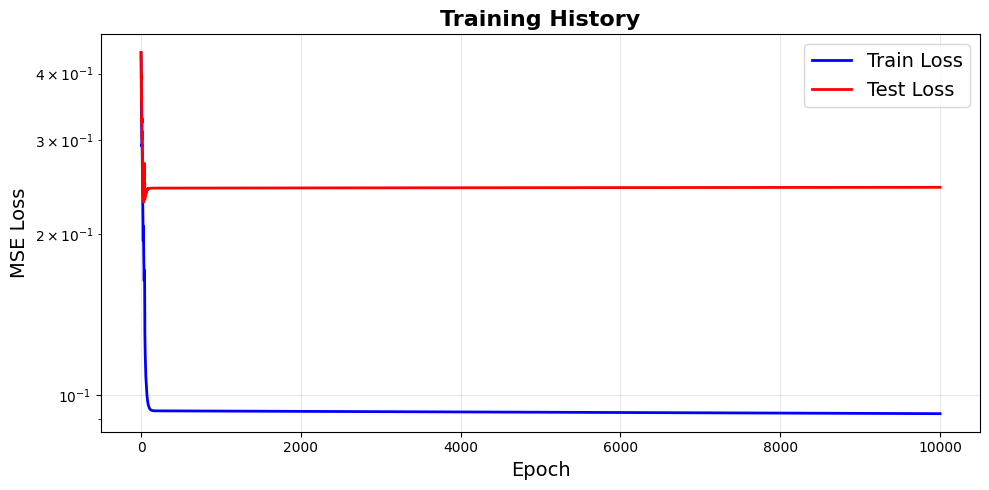

In [37]:
# ==========================================
# Training Loop
# ==========================================

train_losses = []
test_losses = []
best_test_loss = float('inf')
checkpoint_path = 'best_deeponet_burgers.pt'

# Get trunk tensor (same for all samples)
trunk_coords = train_dataset.trunk_data

print("Starting training...\n")
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0.0

    for u0_batch, u_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass (trunk is shared across batch)
        u_pred = model(u0_batch, trunk_coords)
        loss = criterion(u_pred, u_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()

    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)

    # Evaluation phase
    model.eval()
    test_loss_epoch = 0.0

    with torch.no_grad():
        for u0_batch, u_batch in test_loader:
            u_pred = model(u0_batch, trunk_coords)
            loss = criterion(u_pred, u_batch)
            test_loss_epoch += loss.item()

    test_loss_epoch /= len(test_loader)
    test_losses.append(test_loss_epoch)

    # Learning rate scheduling
    scheduler.step(test_loss_epoch)

    # Save best model
    if test_loss_epoch < best_test_loss:
        best_test_loss = test_loss_epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss_epoch,
            'test_loss': test_loss_epoch,
            'u0_mean': u0_mean,
            'u0_std': u0_std,
            'trunk_mean': trunk_mean,
            'trunk_std': trunk_std,
            'grid_info': grid_info
        }, checkpoint_path)

    # Print progress
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == num_epochs-1:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss_epoch:.6f} | "
              f"Test Loss: {test_loss_epoch:.6f} | "
              f"Time: {elapsed:.1f}s")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Best test loss: {best_test_loss:.6f}")
print(f"Model saved to: {checkpoint_path}")

# Plot training history
plot_loss(train_losses, test_losses, savefile='training_history.png')

In [38]:
# ==========================================
# Load Best Model and Evaluate
# ==========================================

# Load best checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best test loss: {checkpoint['test_loss']:.6f}\n")

# Predict on test set
print("Generating predictions on test set...")
predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        u0_sample, _ = test_dataset[i]
        u_pred = model(u0_sample.unsqueeze(0), trunk_coords).squeeze(0)
        predictions.append(u_pred.cpu().numpy())

predictions = np.array(predictions)
print(f"Predictions shape: {predictions.shape}")

# Compute relative L2 errors
u_test_np = u_test  # Already numpy array
test_errors = []
for i in range(len(u_test_np)):
    error = compute_relative_l2_error(predictions[i], u_test_np[i])
    test_errors.append(error)

test_errors = np.array(test_errors)
print(f"\nRelative L2 Error Statistics:")
print(f"  Mean: {test_errors.mean():.6f}")
print(f"  Std:  {test_errors.std():.6f}")
print(f"  Min:  {test_errors.min():.6f}")
print(f"  Max:  {test_errors.max():.6f}")
print(f"  Median: {np.median(test_errors):.6f}")


Loaded best model from epoch 34
Best test loss: 0.229670

Generating predictions on test set...
Predictions shape: (8, 5120)

Relative L2 Error Statistics:
  Mean: 0.693161
  Std:  0.059869
  Min:  0.607155
  Max:  0.804242
  Median: 0.683766


Grid dimensions: nx=16, ny=16, nt=20
Total trunk points per sample: 5120
Expected: 5120

Visualizing 4 test samples at 4 time snapshots
Time indices: [0, 6, 13, 19]
Time values: [np.float64(0.0), np.float64(0.30150753768844224), np.float64(0.6532663316582915), np.float64(0.9547738693467337)]

Comparison plot saved to: comparison_4x4_grid.png


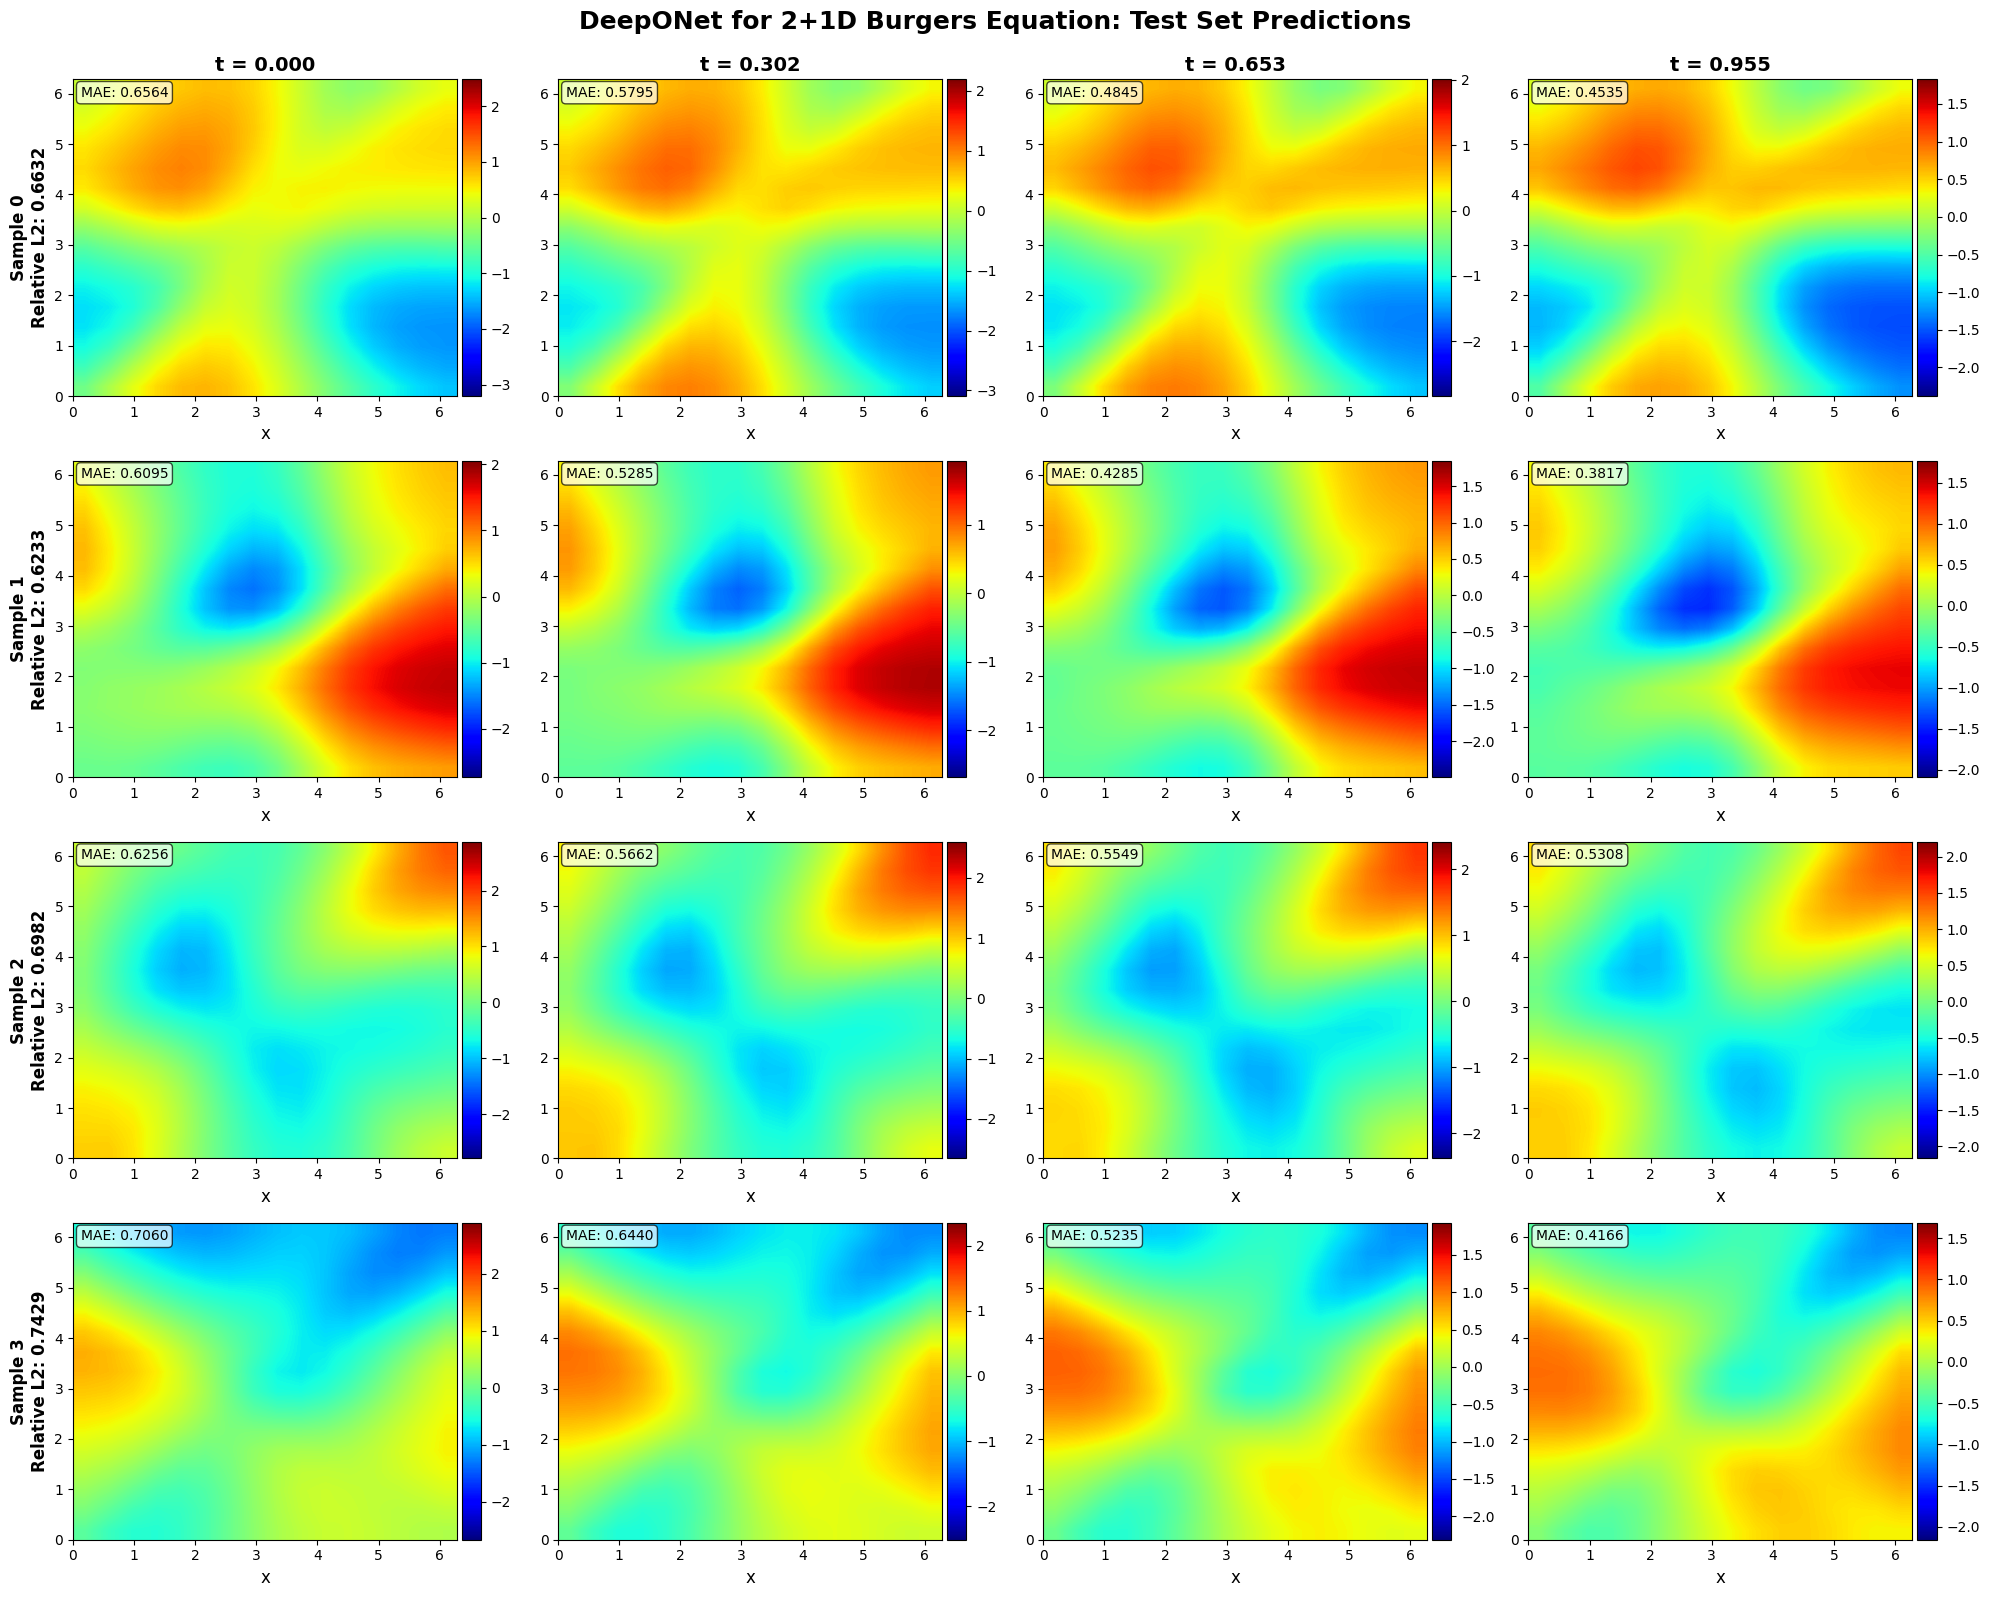

In [25]:


# ==========================================
# Main Comparison Visualization (4×4 Grid)
# ==========================================

# Extract spatial grid information
M = trunk_all.shape[0]
# Assume trunk is structured as (nx*ny*nt, 3)
# We need to determine nx, ny, nt from the trunk data
x_unique = np.unique(trunk_all[:, 0])
y_unique = np.unique(trunk_all[:, 1])
t_unique = np.unique(trunk_all[:, 2])

nx_grid = len(x_unique)
ny_grid = len(y_unique)
nt = len(t_unique)

print(f"Grid dimensions: nx={nx_grid}, ny={ny_grid}, nt={nt}")
print(f"Total trunk points per sample: {M}")
print(f"Expected: {nx_grid * ny_grid * nt}")

# Select test samples to visualize
num_samples = 4
sample_indices = [0, 1, 2, 3]  # First 4 test samples

# Select time snapshots to visualize
time_snapshots = [0, nt//3, 2*nt//3, nt-1]  # Early, mid1, mid2, final

print(f"\nVisualizing {num_samples} test samples at {len(time_snapshots)} time snapshots")
print(f"Time indices: {time_snapshots}")
print(f"Time values: {[t_unique[i] for i in time_snapshots]}")

# Create 4×4 grid visualization
fig, axes = plt.subplots(num_samples, len(time_snapshots), figsize=(20, 16))
fig.suptitle('DeepONet for 2+1D Burgers Equation: Test Set Predictions',
             fontsize=18, fontweight='bold', y=0.995)

for row, sample_idx in enumerate(sample_indices):
    # Get truth and prediction for this sample
    truth_full = u_test[sample_idx]  # Shape: (M,)
    pred_full = predictions[sample_idx]  # Shape: (M,)
    u0_sample = u0_test[sample_idx]  # Shape: (nx, ny)

    # Compute relative L2 error for this sample
    rel_error = compute_relative_l2_error(pred_full, truth_full)

    for col, t_idx in enumerate(time_snapshots):
        ax = axes[row, col]

        # Extract data at this time snapshot
        # Assuming data is ordered as [t0: all (x,y), t1: all (x,y), ...]
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_full[start_idx:end_idx].reshape(nx_grid, ny_grid)
        pred_t = pred_full[start_idx:end_idx].reshape(nx_grid, ny_grid)

        # Plot prediction
        vmin = min(truth_t.min(), pred_t.min())
        vmax = max(truth_t.max(), pred_t.max())

        plot_2d_field(ax, pred_t, extent=[0, 2*np.pi, 0, 2*np.pi],
                     cmap='jet', vmin=vmin, vmax=vmax)

        # Add title with time and error info
        if row == 0:
            ax.set_title(f't = {t_unique[t_idx]:.3f}', fontsize=14, fontweight='bold')

        if col == 0:
            ax.set_ylabel(f'Sample {sample_idx}\nRelative L2: {rel_error:.4f}',
                         fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')

        # Add text overlay showing truth vs pred difference
        point_error = np.abs(pred_t - truth_t).mean()
        ax.text(0.02, 0.98, f'MAE: {point_error:.4f}',
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('comparison_4x4_grid.png', dpi=150, bbox_inches='tight')
print("\nComparison plot saved to: comparison_4x4_grid.png")
plt.show()



Detailed analysis for test sample 0
Time snapshots: [np.float64(0.0), np.float64(0.30150753768844224), np.float64(0.6030150753768845), np.float64(0.9547738693467337)]
Detailed comparison saved to: detailed_comparison.png


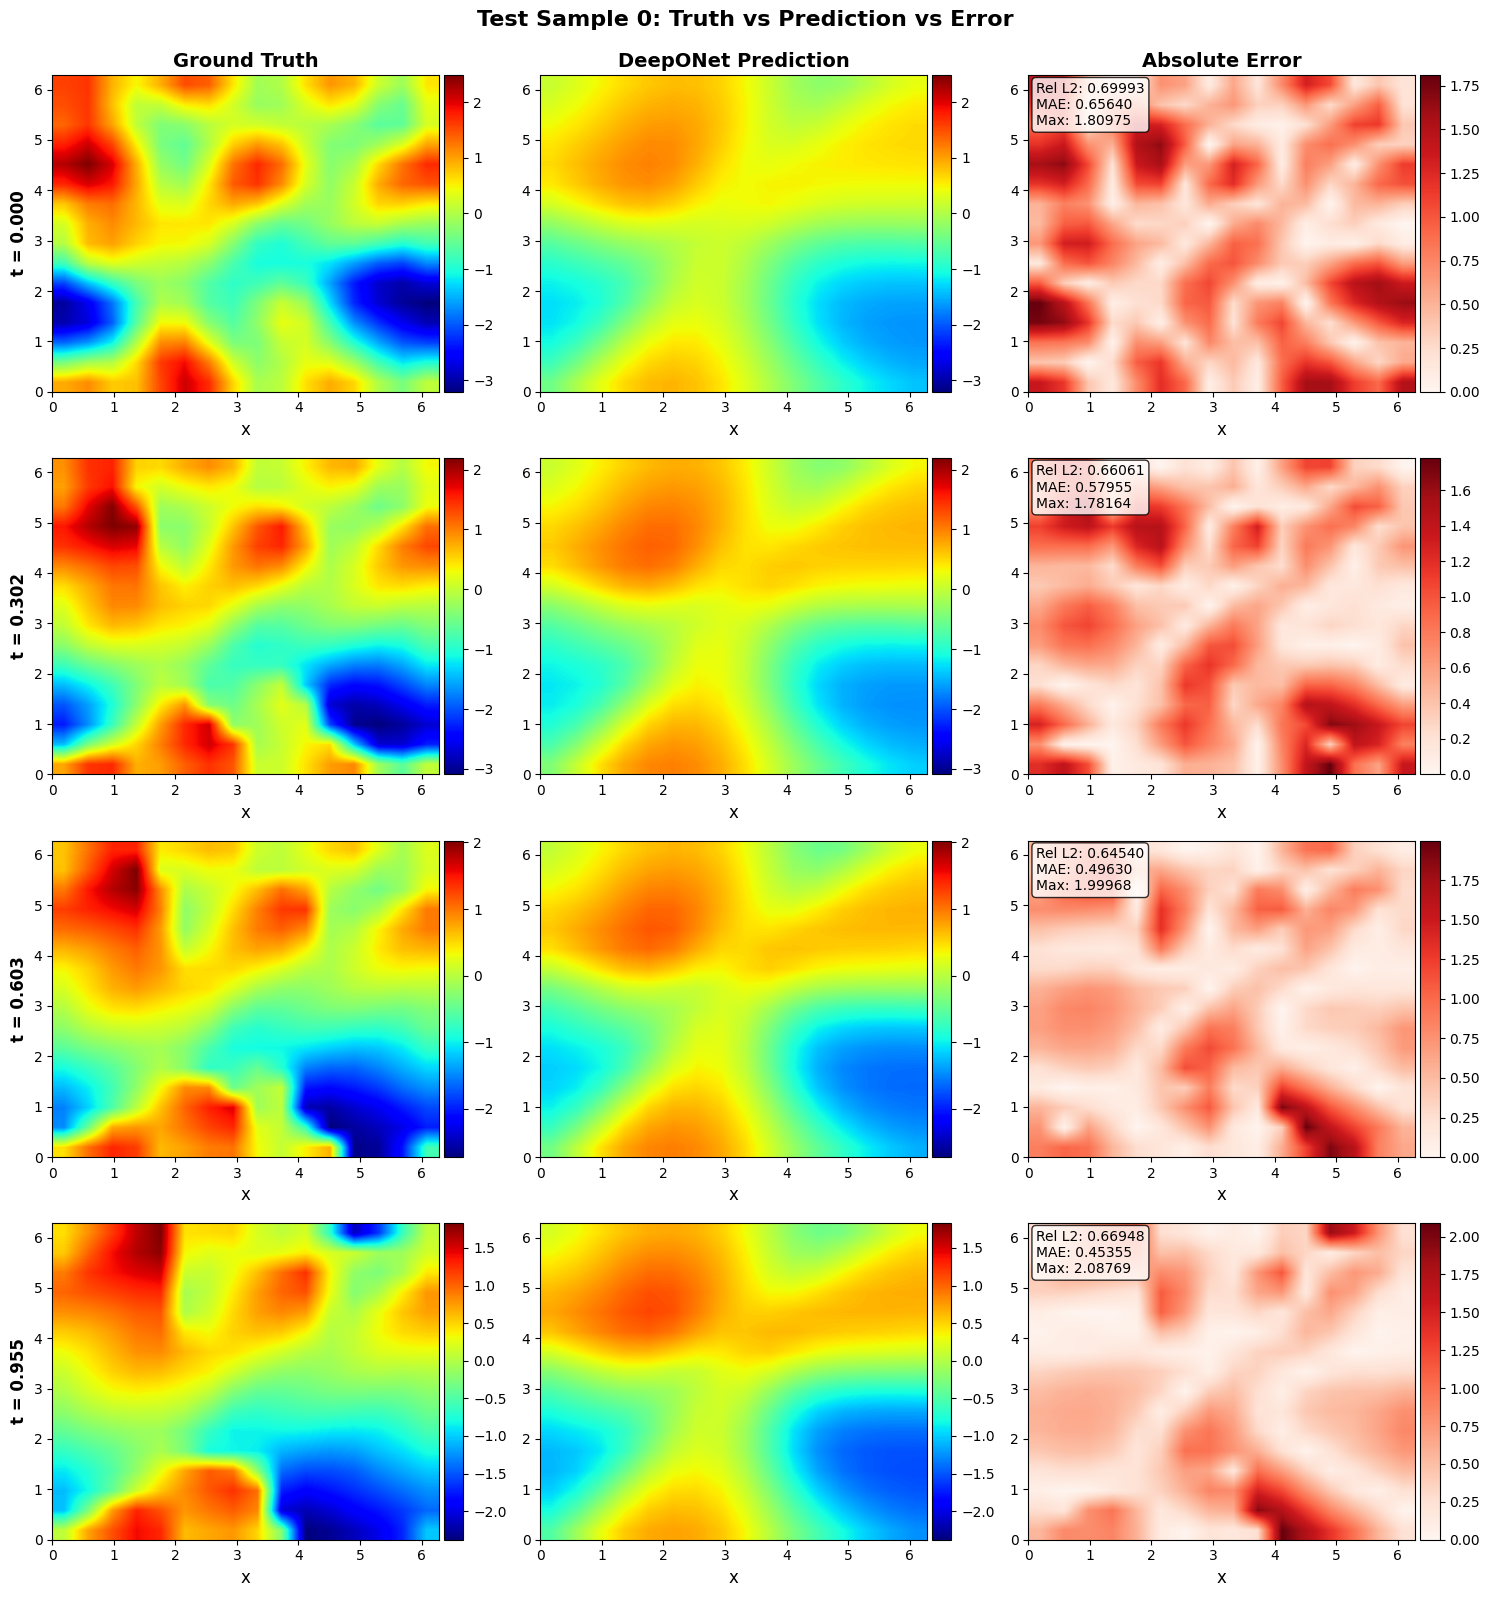

In [26]:

# ==========================================
# Detailed Comparison: Truth, Prediction, Error
# ==========================================

# Select one sample for detailed analysis
detail_sample_idx = 0
num_time_snapshots = 4
time_indices_detail = np.linspace(0, nt-1, num_time_snapshots, dtype=int)

truth_detail = u_test[detail_sample_idx]
pred_detail = predictions[detail_sample_idx]
u0_detail = u0_test[detail_sample_idx]

print(f"Detailed analysis for test sample {detail_sample_idx}")
print(f"Time snapshots: {[t_unique[i] for i in time_indices_detail]}")

fig, axes = plt.subplots(num_time_snapshots, 3, figsize=(15, 16))
fig.suptitle(f'Test Sample {detail_sample_idx}: Truth vs Prediction vs Error',
             fontsize=16, fontweight='bold', y=0.995)

for row, t_idx in enumerate(time_indices_detail):
    # Extract data at this time
    start_idx = t_idx * nx_grid * ny_grid
    end_idx = start_idx + nx_grid * ny_grid

    truth_t = truth_detail[start_idx:end_idx].reshape(nx_grid, ny_grid)
    pred_t = pred_detail[start_idx:end_idx].reshape(nx_grid, ny_grid)
    error_t = np.abs(truth_t - pred_t)

    # Global color limits for truth and prediction
    vmin = min(truth_t.min(), pred_t.min())
    vmax = max(truth_t.max(), pred_t.max())

    # Truth
    ax = axes[row, 0]
    plot_2d_field(ax, truth_t, cmap='jet', vmin=vmin, vmax=vmax)
    if row == 0:
        ax.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax.set_ylabel(f't = {t_unique[t_idx]:.3f}', fontsize=12, fontweight='bold')

    # Prediction
    ax = axes[row, 1]
    plot_2d_field(ax, pred_t, cmap='jet', vmin=vmin, vmax=vmax)
    if row == 0:
        ax.set_title('DeepONet Prediction', fontsize=14, fontweight='bold')
    ax.set_ylabel('')

    # Absolute Error
    ax = axes[row, 2]
    plot_2d_field(ax, error_t, cmap='Reds', vmin=0, vmax=error_t.max())
    if row == 0:
        ax.set_title('Absolute Error', fontsize=14, fontweight='bold')
    ax.set_ylabel('')

    # Add error statistics
    rel_l2 = compute_relative_l2_error(pred_t.flatten(), truth_t.flatten())
    mae = error_t.mean()
    max_err = error_t.max()
    ax.text(0.02, 0.98, f'Rel L2: {rel_l2:.5f}\nMAE: {mae:.5f}\nMax: {max_err:.5f}',
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('detailed_comparison.png', dpi=150, bbox_inches='tight')
print("Detailed comparison saved to: detailed_comparison.png")
plt.show()




Analyzing temporal evolution of prediction error...

Temporal evolution plot saved to: temporal_evolution.png


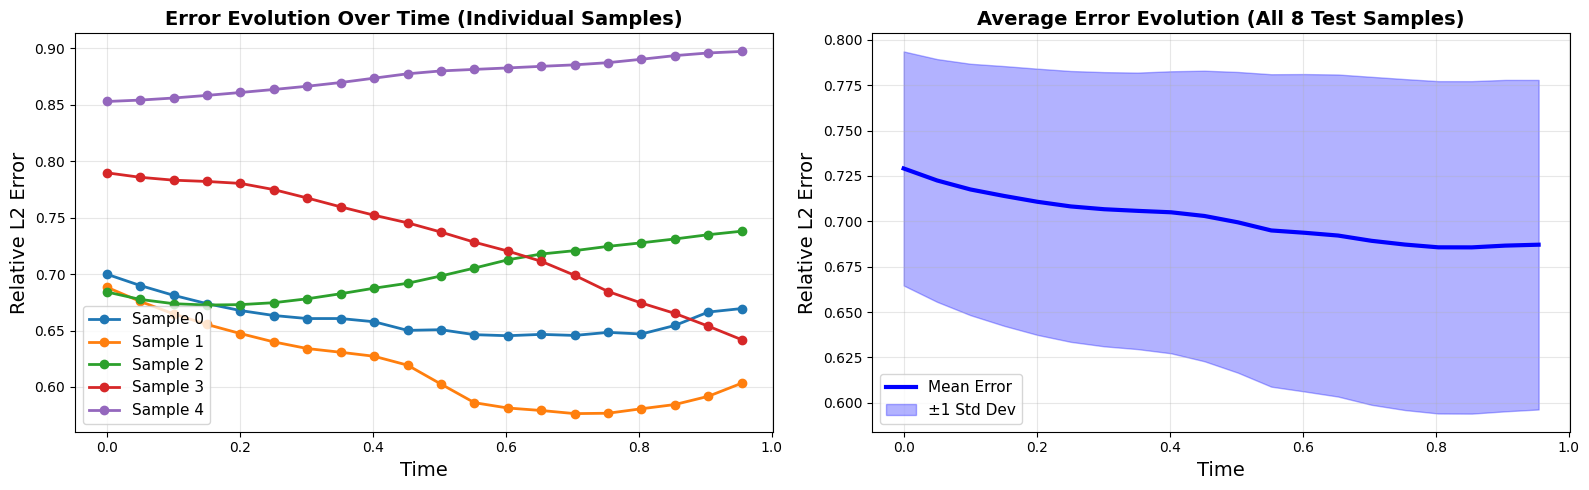


Temporal Error Statistics:
  Initial time (t=0.000): mean=0.729118, std=0.064453
  Final time (t=0.955): mean=0.687124, std=0.090753
  Maximum mean error over time: 0.729118 at t=0.000
  Minimum mean error over time: 0.685650 at t=0.854


In [27]:
# ==========================================
# Temporal Evolution Analysis
# ==========================================

# Analyze how prediction error evolves over time
print("Analyzing temporal evolution of prediction error...\n")

# Select a few test samples to analyze
analysis_samples = [0, 1, 2, 3, 4]
errors_over_time = np.zeros((len(analysis_samples), nt))

for i, sample_idx in enumerate(analysis_samples):
    truth_sample = u_test[sample_idx]
    pred_sample = predictions[sample_idx]

    for t_idx in range(nt):
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_sample[start_idx:end_idx]
        pred_t = pred_sample[start_idx:end_idx]

        rel_error_t = compute_relative_l2_error(pred_t, truth_t)
        errors_over_time[i, t_idx] = rel_error_t

# Plot temporal evolution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual sample trajectories
ax = axes[0]
for i, sample_idx in enumerate(analysis_samples):
    ax.plot(t_unique, errors_over_time[i], marker='o', label=f'Sample {sample_idx}',
            linewidth=2, markersize=6)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Relative L2 Error', fontsize=14)
ax.set_title('Error Evolution Over Time (Individual Samples)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Average and statistics across all test samples
ax = axes[1]
all_errors_over_time = np.zeros((len(test_errors), nt))

for sample_idx in range(len(u_test)):
    truth_sample = u_test[sample_idx]
    pred_sample = predictions[sample_idx]

    for t_idx in range(nt):
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_sample[start_idx:end_idx]
        pred_t = pred_sample[start_idx:end_idx]

        rel_error_t = compute_relative_l2_error(pred_t, truth_t)
        all_errors_over_time[sample_idx, t_idx] = rel_error_t

mean_errors = all_errors_over_time.mean(axis=0)
std_errors = all_errors_over_time.std(axis=0)

ax.plot(t_unique, mean_errors, 'b-', linewidth=3, label='Mean Error')
ax.fill_between(t_unique, mean_errors - std_errors, mean_errors + std_errors,
                alpha=0.3, color='blue', label='±1 Std Dev')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Relative L2 Error', fontsize=14)
ax.set_title(f'Average Error Evolution (All {len(u_test)} Test Samples)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_evolution.png', dpi=150, bbox_inches='tight')
print("Temporal evolution plot saved to: temporal_evolution.png")
plt.show()

# Print summary statistics
print(f"\nTemporal Error Statistics:")
print(f"  Initial time (t={t_unique[0]:.3f}): mean={all_errors_over_time[:, 0].mean():.6f}, std={all_errors_over_time[:, 0].std():.6f}")
print(f"  Final time (t={t_unique[-1]:.3f}): mean={all_errors_over_time[:, -1].mean():.6f}, std={all_errors_over_time[:, -1].std():.6f}")
print(f"  Maximum mean error over time: {mean_errors.max():.6f} at t={t_unique[mean_errors.argmax()]:.3f}")
print(f"  Minimum mean error over time: {mean_errors.min():.6f} at t={t_unique[mean_errors.argmin()]:.3f}")